In [1]:
import os
from pathlib import Path
import pandas as pd
import sqlite3
import numpy as np

In [2]:
from onee.utils import get_move_in_year, plot_time_evolution, plot_time_evolution

In [3]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

In [4]:
db_path = PROJECT_ROOT / 'data/ONEE_Regional_COMPLETE_2007_2023.db'

db_regional = sqlite3.connect(db_path)

In [9]:
query_features = f"""
SELECT Year as annee, 
       SUM(GDP_Millions_DH) as pib_mdh,
       SUM(GDP_Primaire) as gdp_primaire,
       SUM(GDP_Secondaire) as gdp_secondaire,
       SUM(GDP_Tertiaire) as gdp_tertiaire,
       AVG(temp) as temperature_annuelle
FROM regional_features
GROUP BY Year
"""
df_features = pd.read_sql_query(query_features, db_regional)

In [5]:
db_cd_path = PROJECT_ROOT / "data/cd_database_2013_2023.db"

db_cd = sqlite3.connect(db_cd_path)

In [6]:
query_contrats = "SELECT * from cd"
df_contrats = pd.read_sql_query(query_contrats, db_cd)

query_activite_features = "SELECT * from active_contrats_features"
df_activite_features = pd.read_sql_query(query_activite_features, db_cd)

In [7]:
df_a = df_activite_features[df_activite_features["activite"] == "ADMINISTRATION PUBLIQUE"]

In [12]:
df_a = df_a.merge(df_features, on ="annee")

In [13]:
df_a.columns

Index(['activite', 'annee', 'total_active_contrats', 'just_started',
       'two_years_old', 'three_years_old', 'more_than_3_years_old', 'pib_mdh',
       'gdp_primaire', 'gdp_secondaire', 'gdp_tertiaire',
       'temperature_annuelle'],
      dtype='object')

In [23]:
min(float("inf"), 2323)

2323

C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_16888\3069241455.py:17: RuntimeWarning: divide by zero encountered in log
  log_y_user = np.log(y_user)
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_16888\3069241455.py:18: RuntimeWarning: divide by zero encountered in log
  log_y_ecm = np.log(y_ecm)


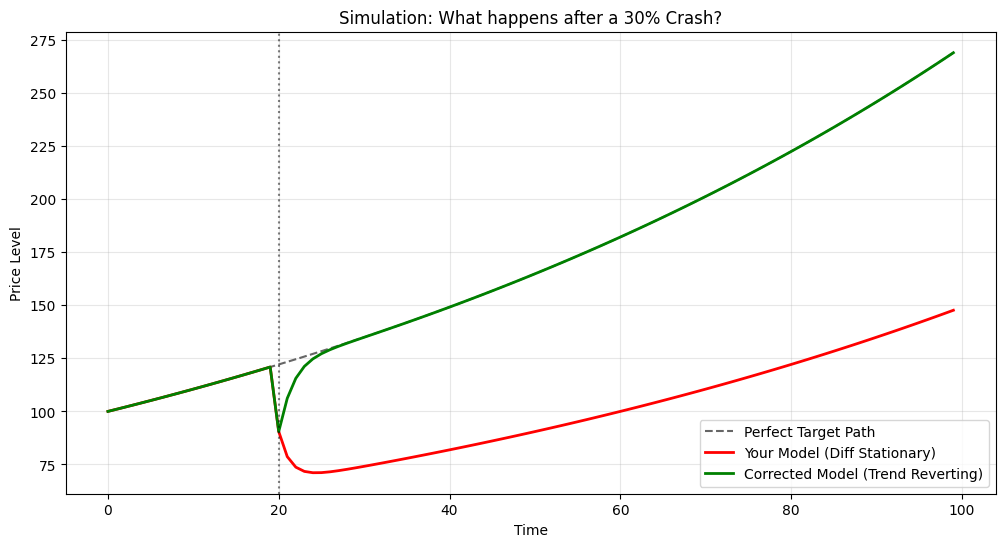

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
T = 100
mu = 0.01  # Target growth rate (1% per step)
rho = 0.5  # Speed parameter

# Initialize two series
# y_user: Your model (Difference Stationary)
# y_ecm:  The Correct model (Trend Stationary / Error Correction)
y_user = np.zeros(T)
y_ecm = np.zeros(T)
y_user[0] = y_ecm[0] = 100

# Log prices for calculation
log_y_user = np.log(y_user)
log_y_ecm = np.log(y_ecm)

# Track the theoretical "perfect trend" (where we WANT to be)
perfect_trend = 100 * np.exp(mu * np.arange(T))

# Simulation Loop
for t in range(1, T):
    # 1. Calculate the previous growth rate (needed for your lag terms)
    if t > 1:
        prev_change_user = log_y_user[t-1] - log_y_user[t-2]
    else:
        prev_change_user = mu # start assumption

    # --- FORCE A CRASH AT T=20 ---
    if t == 20:
        shock = -0.30  # -30% crash
    else:
        shock = 0.0

    # --- MODEL A: YOUR FORMULATION ---
    # Δlog(y) depends only on PREVIOUS CHANGE (plus shock)
    # It has NO idea where the "Perfect Trend" line is.
    change_user = (1-rho)*mu + rho*prev_change_user + shock
    log_y_user[t] = log_y_user[t-1] + change_user

    # --- MODEL B: ERROR CORRECTION MODEL (ECM) ---
    # Δlog(y) depends on DISTANCE from the trend.
    # (log_y_ecm[t-1] - np.log(perfect_trend[t-1])) measures the "error"
    term_ecm = -rho * (log_y_ecm[t-1] - np.log(perfect_trend[t-1]))
    change_ecm = mu + term_ecm + shock
    log_y_ecm[t] = log_y_ecm[t-1] + change_ecm

# Convert back to price levels
y_user = np.exp(log_y_user)
y_ecm = np.exp(log_y_ecm)

# --- PLOTTING ---
plt.figure(figsize=(12, 6))

# Plot the Perfect Trend
plt.plot(perfect_trend, 'k--', label='Perfect Target Path', alpha=0.6)

# Plot Your Model
plt.plot(y_user, 'r-', linewidth=2, label='Your Model (Diff Stationary)')

# Plot ECM Model
plt.plot(y_ecm, 'g-', linewidth=2, label='Corrected Model (Trend Reverting)')

plt.title('Simulation: What happens after a 30% Crash?')
plt.xlabel('Time')
plt.ylabel('Price Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=20, color='k', linestyle=':', alpha=0.5, label='Shock Event')
plt.show()

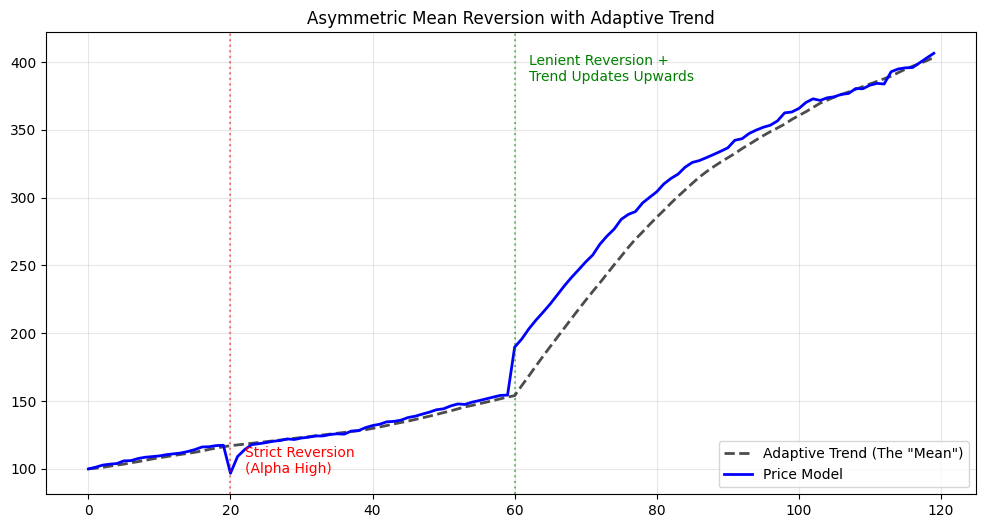

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_asymmetric_model():
    T = 120
    mu_base = 0.005  # Base growth 0.5%
    
    # --- THE HYPERPARAMETERS ---
    # 1. Reversion Speeds
    alpha_down = 0.60  # STRICT: Snap back immediately if below trend
    alpha_up   = 0.05  # LENIENT: Very slow pull back if above trend
    
    # 2. Trend Adaptability
    # How much does the "Trend" accept the new high prices?
    beta_adapt = 0.20  
    
    # Initialization
    log_y = np.zeros(T)
    trend_level = np.zeros(T)
    dynamic_mu = np.zeros(T)
    
    log_y[0] = np.log(100)
    trend_level[0] = np.log(100)
    dynamic_mu[0] = mu_base

    # Simulation
    for t in range(1, T):
        # 1. Calculate the Gap (Error) from the previous step
        prev_gap = log_y[t-1] - trend_level[t-1]
        
        # 2. Determine Reversion Speed (Asymmetric)
        if prev_gap < 0:
            # We are BELOW trend (Crash) -> Strict Reversion
            current_alpha = alpha_down
        else:
            # We are ABOVE trend (Boom) -> Lenient Reversion
            current_alpha = alpha_up

        # 3. Update the Trend Growth (Adaptive)
        # If gap is positive, we slightly increase our expectation of growth
        # This is the "Leaning In" behavior
        upside_pressure = max(0, prev_gap) 
        
        # Simple adaptive mechanism: Current Mu depends on base + upside pressure
        # (In a real model, you might smooth this pressure term)
        dynamic_mu[t] = mu_base + (beta_adapt * upside_pressure)
        
        # Update Trend Level
        trend_level[t] = trend_level[t-1] + dynamic_mu[t]

        # 4. Calculate Price Change
        # Change = Expected Growth + Reversion Correction + Noise
        
        # Create Shocks manually for demonstration
        shock = np.random.normal(0, 0.005) 
        if t == 20: shock = -0.20  # CRASH
        if t == 60: shock =  0.20  # BOOM
        
        change = dynamic_mu[t] - (current_alpha * prev_gap) + shock
        log_y[t] = log_y[t-1] + change

    return np.exp(log_y), np.exp(trend_level)

# Run Simulation
price, trend = simulate_asymmetric_model()

# Plotting
plt.figure(figsize=(12, 6))

# Plot Trend
plt.plot(trend, 'k--', linewidth=2, label='Adaptive Trend (The "Mean")', alpha=0.7)

# Plot Price
plt.plot(price, 'b-', linewidth=2, label='Price Model')

# Annotations
plt.axvline(x=20, color='r', linestyle=':', alpha=0.5)
plt.text(22, min(price), "Strict Reversion\n(Alpha High)", color='red')

plt.axvline(x=60, color='g', linestyle=':', alpha=0.5)
plt.text(62, max(price)*0.95, "Lenient Reversion +\nTrend Updates Upwards", color='green')

plt.title('Asymmetric Mean Reversion with Adaptive Trend')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
import numpy as np
from scipy.optimize import minimize
from typing import Tuple, Optional, Dict, List
from sklearn.preprocessing import StandardScaler

# Assuming these exist in your codebase
# from your_module import ParamIntrospectionMixin, BaseForecastModel 

class AsymmetricAdaptiveTrendModel: # Inherit from your Mixins here
    """
    Asymmetric Adaptive Trend Model (AATM).
    
    Dynamics:
        1. Gap calculation: Gap_t = log(y_t) - Trend_t
        2. Asymmetric Reversion: α depends on whether Gap is + or -
        3. Adaptive Trend: Trend leans into positive gaps (bubbles/growth) 
           but resists negative gaps (crashes).

    Parameters:
        - mu_base: The fundamental long-run growth rate.
        - alpha_down: Reversion speed when price < trend (Crash recovery).
        - alpha_up: Reversion speed when price > trend (Bubble correction).
        - beta_adapt: How much the trend 'leans in' to price increases.
    """
    
    SUPPORTED_HYPERPARAMS = {
        "include_exog",
        "l2_penalty",
        "alpha_down_bounds",
        "alpha_up_bounds",
        "beta_adapt_bounds",
        "mu_bounds",
        "use_asymmetric_loss",
        "underestimation_penalty"
    }

    def __init__(self, 
                 include_exog: bool = True,
                 l2_penalty: float = 10.0,
                 alpha_down_bounds: Tuple[float, float] = (0.1, 1.5), # Default strict
                 alpha_up_bounds: Tuple[float, float] = (0.0, 0.5),   # Default lenient
                 beta_adapt_bounds: Tuple[float, float] = (0.0, 0.5),
                 mu_bounds: Tuple[float, float] = (0.0, None),
                 use_asymmetric_loss: bool = False,
                 underestimation_penalty: float = 2.0, 
                 **kwargs):
        
        # self._process_init(locals(), AsymmetricAdaptiveTrendModel) # Uncomment if using your Mixin

        self.include_exog = include_exog
        self.l2_penalty = l2_penalty
        self.alpha_down_bounds = alpha_down_bounds
        self.alpha_up_bounds = alpha_up_bounds
        self.beta_adapt_bounds = beta_adapt_bounds
        self.mu_bounds = mu_bounds
        self.use_asymmetric_loss = use_asymmetric_loss
        self.underestimation_penalty = underestimation_penalty
        
        # Fitted parameters
        self.mu_base = None
        self.alpha_down = None
        self.alpha_up = None
        self.beta_adapt = None
        self.gamma = None
        self.scaler = None
        
        # State for prediction
        self.last_y = None
        self.last_trend_level = None
        self.last_dynamic_mu = None

    def _reconstruct_path(self, params: np.ndarray, log_y: np.ndarray, 
                          X_scaled: Optional[np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Internal helper to simulate the trend path over history given specific parameters.
        Returns: (y_pred_log_diff, final_state_tuple)
        """
        # 1. Unpack Parameters
        idx = 0
        mu_base = params[idx]; idx += 1
        alpha_down = params[idx]; idx += 1
        alpha_up = params[idx]; idx += 1
        beta_adapt = params[idx]; idx += 1
        
        gamma = np.array([])
        if self.include_exog and X_scaled is not None:
            gamma = params[idx:]

        T = len(log_y)
        
        # Initialize State variables
        # We assume the trend started exactly where the price started
        trend_level = log_y[0] 
        dynamic_mu = mu_base
        
        predictions = []
        
        # 2. Iterate through history to build the dynamic trend
        # We predict t+1 based on information at t
        for t in range(T - 1):
            # Current state at t
            current_log_y = log_y[t]
            
            # A. Calculate Gap
            gap = current_log_y - trend_level
            
            # B. Determine Asymmetric Alpha
            if gap < 0:
                current_alpha = alpha_down
            else:
                current_alpha = alpha_up
                
            # C. Update Trend (Adaptive)
            # "Lean in" logic: if gap is positive, trend grows faster
            upside_pressure = max(0, gap)
            dynamic_mu = mu_base + (beta_adapt * upside_pressure)
            
            # The trend level for NEXT step (t+1)
            trend_level = trend_level + dynamic_mu
            
            # D. Predict Growth for t+1
            # Δlog(y) = Expected_Trend_Growth - Correction + Exog
            pred_change = dynamic_mu - (current_alpha * gap)
            
            if self.include_exog and X_scaled is not None:
                pred_change += np.dot(X_scaled[t], gamma)
                
            predictions.append(pred_change)

        return np.array(predictions), (trend_level, dynamic_mu)

    def _objective(self, params: np.ndarray, log_y: np.ndarray, 
                   X_scaled: Optional[np.ndarray]) -> float:
        
        # Reconstruct the path to get predictions
        y_pred_changes, _ = self._reconstruct_path(params, log_y, X_scaled)
        
        # True changes (actual growth rates)
        # log_y has length T, so diff is T-1
        y_true_changes = np.diff(log_y) 
        
        errors = y_true_changes - y_pred_changes
        
        # Compute Loss
        if self.use_asymmetric_loss:
            squared_errors = errors ** 2
            underestimation_mask = errors > 0 
            weighted_errors = squared_errors.copy()
            weighted_errors[underestimation_mask] *= self.underestimation_penalty
            loss = np.mean(weighted_errors)
        else:
            loss = np.mean(errors ** 2)
            
        # L2 Penalty on Gamma only
        idx_gamma_start = 4 # mu, a_down, a_up, beta
        if self.include_exog and len(params) > idx_gamma_start:
            gamma_params = params[idx_gamma_start:]
            l2_term = self.l2_penalty * np.sum(gamma_params ** 2)
        else:
            l2_term = 0.0
            
        return loss + l2_term

    def fit(self, *, y=None, X=None, **kwargs):
        y = np.asarray(y, dtype=float).flatten()
        log_y = np.log(y)
        
        # --- Exogenous Feature Handling (Same as your code) ---
        X_scaled = None
        if self.include_exog and X is not None:
            X = np.asarray(X, dtype=float)
            if X.ndim == 1: X = X.reshape(-1, 1)
            X_aligned = X[1:] # Align with predictions
            
            if np.isnan(X_aligned).any():
                col_means = np.nanmean(X_aligned, axis=0)
                for i in range(X_aligned.shape[1]):
                    X_aligned[np.isnan(X_aligned[:, i]), i] = col_means[i]
            
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X_aligned)

        # --- Initialization ---
        # Guess mu based on average growth
        mu_init = np.mean(np.diff(log_y))
        
        # [mu_base, alpha_down, alpha_up, beta_adapt]
        params_init = [mu_init, 0.5, 0.1, 0.1] 
        
        bounds = [
            self.mu_bounds,
            self.alpha_down_bounds,
            self.alpha_up_bounds,
            self.beta_adapt_bounds
        ]
        
        if self.include_exog and X_scaled is not None:
            k = X_scaled.shape[1]
            params_init.extend([0.0] * k)
            bounds.extend([(None, None)] * k)

        # --- Optimization ---
        result = minimize(
            fun=self._objective,
            x0=np.array(params_init),
            args=(log_y, X_scaled),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000, 'ftol': 1e-9}
        )

        # --- Store Parameters ---
        self.mu_base = result.x[0]
        self.alpha_down = result.x[1]
        self.alpha_up = result.x[2]
        self.beta_adapt = result.x[3]
        
        if self.include_exog and X_scaled is not None:
            self.gamma = result.x[4:]
        else:
            self.gamma = np.array([])

        # --- CRITICAL: SET FINAL STATE ---
        # We must run the path one last time to find out where the 
        # Trend Level ended up at time T, so we can predict T+1.
        _, final_state = self._reconstruct_path(result.x, log_y, X_scaled)
        
        self.last_trend_level = final_state[0] # Trend at T-1 (aligned for next step)
        self.last_dynamic_mu = final_state[1]  # Growth used for next step
        self.last_y = y[-1]
        
        return self

    def predict(self, X_next: Optional[np.ndarray] = None) -> float:
        """Predicts the next level y_{t+1} based on stored state."""
        
        # 1. Calculate Gap at the end of training (or previous step)
        last_log_y = np.log(self.last_y)
        gap = last_log_y - self.last_trend_level
        
        # 2. Determine Alpha
        if gap < 0:
            current_alpha = self.alpha_down
        else:
            current_alpha = self.alpha_up
            
        # 3. Calculate Prediction (Growth Rate)
        # Δlog(y) = μ_dynamic - α * Gap + Exog
        pred_growth = self.last_dynamic_mu - (current_alpha * gap)
        
        if self.include_exog and X_next is not None and self.scaler is not None:
            X_next = np.asarray(X_next, dtype=float).flatten().reshape(1, -1)
            if np.isnan(X_next).any(): X_next = np.nan_to_num(X_next, nan=0.0)
            X_next_scaled = self.scaler.transform(X_next)
            pred_growth += np.dot(X_next_scaled[0], self.gamma)
            
        # 4. Convert to Level
        y_pred = self.last_y * np.exp(pred_growth)
        
        return float(y_pred)

    def forecast_horizon(self, start_year: int, horizon: int, 
                        df_features, df_monthly, feature_config: dict, 
                        monthly_clients_lookup=None):
        """
        Iterative forecasting that updates the internal Trend state.
        """
        preds = []
        
        # We need to preserve the 'real' state to restore it after forecasting
        # so we don't corrupt the model if we call predict() again
        saved_y = self.last_y
        saved_trend = self.last_trend_level
        saved_mu = self.last_dynamic_mu

        for h in range(1, horizon + 1):
            target_year = start_year + h

            # (Placeholder function call from your snippet)
            # x_next = build_growth_rate_features(...) 
            # For this snippet, I assume x_next is None or handled externally
            x_input = None 

            # 1. Predict Price
            y_pred = self.predict(x_input)
            preds.append((target_year, y_pred))

            # 2. Update State for Next Iteration (t+2)
            # We must simulate the Trend update logic here!
            
            # A. Current Gap (based on the prediction we just made)
            log_y_pred = np.log(y_pred)
            # Note: predict() used last_trend_level. Now we update trend for next step.
            gap = np.log(self.last_y) - self.last_trend_level
            
            # B. Update Trend Expectations (Adaptive Logic)
            upside_pressure = max(0, gap)
            new_dynamic_mu = self.mu_base + (self.beta_adapt * upside_pressure)
            
            new_trend_level = self.last_trend_level + new_dynamic_mu
            
            # C. Commit State
            self.last_y = y_pred
            self.last_trend_level = new_trend_level
            self.last_dynamic_mu = new_dynamic_mu

        # Restore original state
        self.last_y = saved_y
        self.last_trend_level = saved_trend
        self.last_dynamic_mu = saved_mu

        return preds

    def get_params(self) -> Dict:
        return {
            'mu_base': self.mu_base,
            'alpha_down': self.alpha_down,
            'alpha_up': self.alpha_up,
            'beta_adapt': self.beta_adapt,
            'gamma': self.gamma
        }

Fitted Parameters:
Mu Base: 0.0000
Alpha Down (Strict): 0.3000
Alpha Up (Lenient): 0.0681
Beta Adapt (Trend Learning): 0.1000


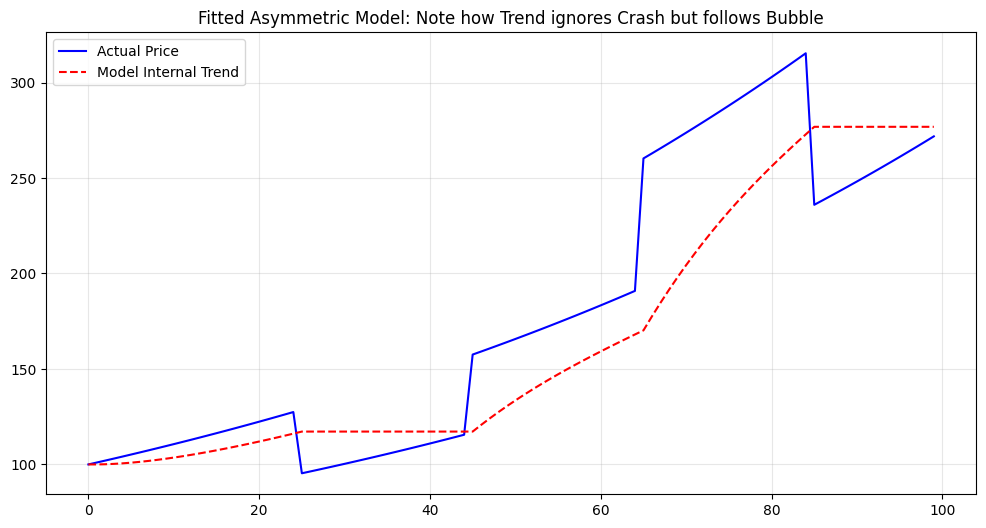

In [4]:
# --- SIMULATION TESTING ---
import matplotlib.pyplot as plt

def test_asymmetric_model():
    # 1. Generate Synthetic Data with a CRASH and a BOOM
    T = 100
    true_trend = np.linspace(np.log(100), np.log(100) + 0.01*T, T)
    y_synthetic_log = true_trend.copy()
    
    # Add Crash at t=25
    y_synthetic_log[25:45] -= 0.30 
    
    # Add Bubble at t=65
    y_synthetic_log[65:85] += 0.30
    
    y_synthetic = np.exp(y_synthetic_log)
    
    # 2. Fit Model
    model = AsymmetricAdaptiveTrendModel(
        include_exog=False,
        alpha_down_bounds=(0.3, 0.9),  # Force it to be strict
        alpha_up_bounds=(0.0, 0.2),    # Force it to be loose
        beta_adapt_bounds=(0.1, 0.5)   # Allow trend adaptation
    )
    
    model.fit(y=y_synthetic)
    
    print("Fitted Parameters:")
    print(f"Mu Base: {model.mu_base:.4f}")
    print(f"Alpha Down (Strict): {model.alpha_down:.4f}")
    print(f"Alpha Up (Lenient): {model.alpha_up:.4f}")
    print(f"Beta Adapt (Trend Learning): {model.beta_adapt:.4f}")
    
    # 3. Reconstruct Path for Visualization
    log_y = np.log(y_synthetic)
    preds_diff, (final_trend, _) = model._reconstruct_path(
        np.array([model.mu_base, model.alpha_down, model.alpha_up, model.beta_adapt]), 
        log_y, 
        None
    )
    
    # Reconstruct Trend Line History (approximation for viz)
    trend_history = [log_y[0]]
    curr_trend = log_y[0]
    curr_mu = model.mu_base
    
    for t in range(T-1):
        gap = log_y[t] - curr_trend
        upside = max(0, gap)
        curr_mu = model.mu_base + (model.beta_adapt * upside)
        curr_trend += curr_mu
        trend_history.append(curr_trend)
        
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(y_synthetic, 'b-', label='Actual Price')
    plt.plot(np.exp(trend_history), 'r--', label='Model Internal Trend')
    plt.title("Fitted Asymmetric Model: Note how Trend ignores Crash but follows Bubble")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the test
test_asymmetric_model()

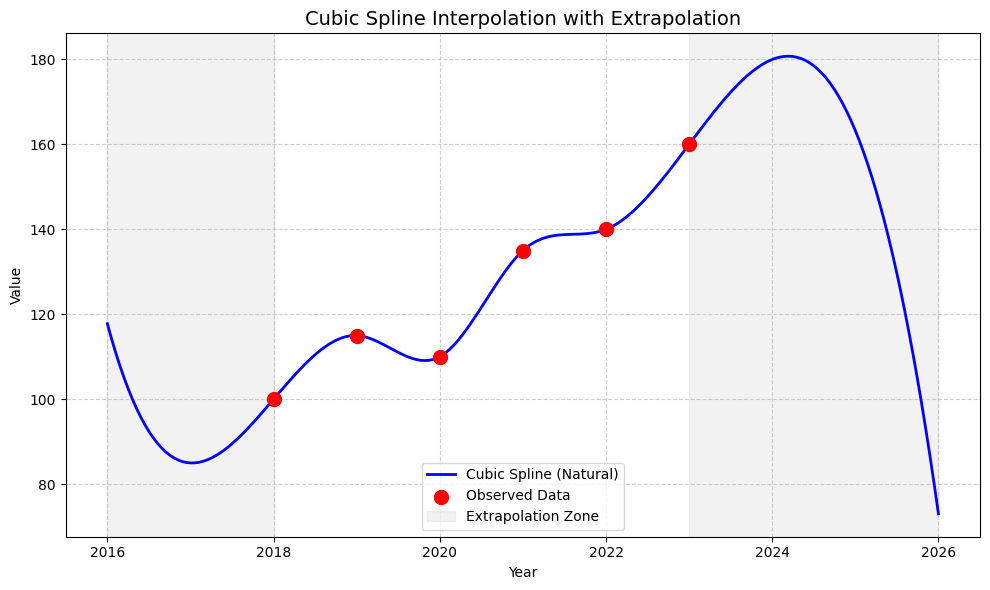

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

def fit_and_predict_spline(years, values, weights=None):
    """
    Adapting your snippet for the demo.
    Note: scipy.interpolate.CubicSpline does not use weights 
    because it forces the line to pass exactly through every point.
    """
    # Sort data just in case (Splines require sorted X values)
    idx = np.argsort(years)
    years_sorted = years[idx]
    values_sorted = values[idx]

    # Create the spline with natural boundary conditions
    cs = CubicSpline(years_sorted, values_sorted, bc_type='natural')
    
    return cs

# --- 1. Setup Dummy Data ---
# Historic years and values
years_data = np.array([2018, 2019, 2020, 2021, 2022, 2023])
values_data = np.array([100, 115, 110, 135, 140, 160]) 

# --- 2. Fit the Model ---
# We pass None for weights as CubicSpline ignores them
spline_model = fit_and_predict_spline(years_data, values_data, weights=None)

# --- 3. Generate Extrapolation Range ---
# We want to see 2 years back and 3 years forward
future_years = np.linspace(2016, 2026, 200)
predicted_values = spline_model(future_years)

# --- 4. Visualization ---
plt.figure(figsize=(10, 6))

# Plot the Spline Curve
plt.plot(future_years, predicted_values, label='Cubic Spline (Natural)', color='blue', linewidth=2)

# Plot the Actual Data Points
plt.scatter(years_data, values_data, color='red', s=100, zorder=5, label='Observed Data')

# Visual formatting to distinguish Interpolation vs Extrapolation
min_yr, max_yr = years_data.min(), years_data.max()

# Shade the Extrapolation areas
plt.axvspan(future_years.min(), min_yr, color='gray', alpha=0.1, label='Extrapolation Zone')
plt.axvspan(max_yr, future_years.max(), color='gray', alpha=0.1)

# Titles and Labels
plt.title("Cubic Spline Interpolation with Extrapolation", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show
plt.tight_layout()
plt.show()

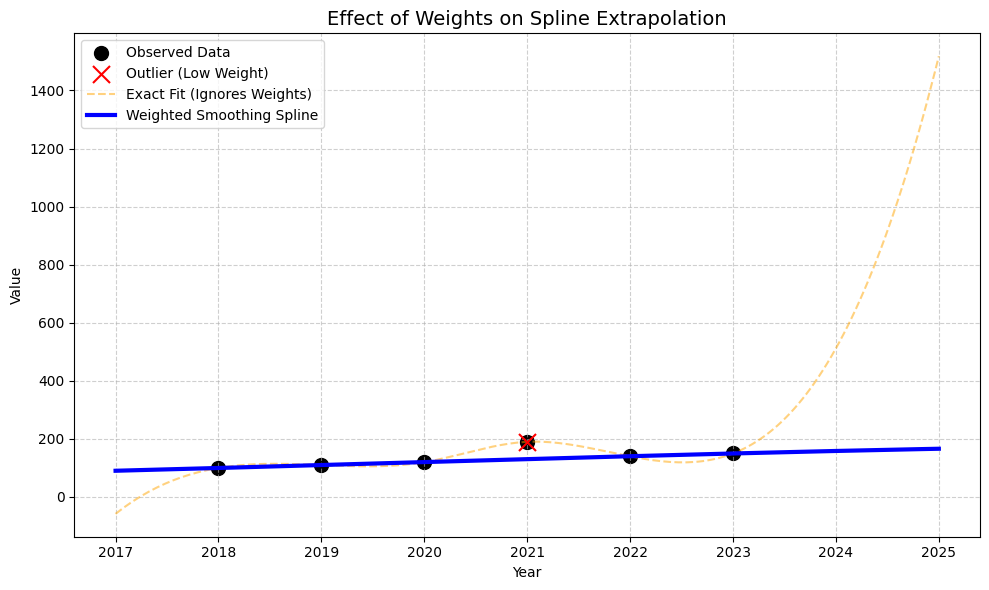

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def fit_smoothing_spline(years, values, weights, smoothing_factor=None):
    """
    k=3: Cubic smoothing spline
    s:   Smoothing factor. 
         - s=0 forces it to hit every point (like CubicSpline)
         - s=None (default) lets Scipy estimate the best smoothing
         - High 's' makes the line stiffer (smoother but less accurate to data)
    """
    # Sort is required
    idx = np.argsort(years)
    years_sorted = years[idx]
    values_sorted = values[idx]
    weights_sorted = weights[idx]

    # UnivariateSpline handles weights
    # w must be positive. Higher w = "Trust this point more"
    spline = UnivariateSpline(years_sorted, values_sorted, w=weights_sorted, k=3, s=smoothing_factor)
    
    return spline

# --- 1. Setup Data with an Outlier ---
years_data = np.array([2018, 2019, 2020, 2021, 2022, 2023])
values_data = np.array([100,  110,  120,  190,  140,  150]) 
# Note: 2021 is 190 (a massive spike/outlier)

# --- 2. Define Weights ---
# We trust all points (weight=1.0) EXCEPT 2021 (weight=0.1)
weights_data = np.array([1.0, 1.0, 1.0, 0.1, 1.0, 1.0])

# --- 3. Fit Models ---
# Model A: Weighted (ignores the outlier because of low weight)
# We set s explicitly to ensure it smooths. If s=0, it ignores weights and hits every point.
smooth_model = fit_smoothing_spline(years_data, values_data, weights_data, smoothing_factor=500)

# Model B: Unweighted/Exact (for comparison, acts like s=0)
exact_model = fit_smoothing_spline(years_data, values_data, np.ones_like(weights_data), smoothing_factor=0)

# --- 4. Extrapolation Range ---
future_years = np.linspace(2017, 2025, 200)

# --- 5. Visualization ---
plt.figure(figsize=(10, 6))

# Plot Data
plt.scatter(years_data, values_data, color='black', s=100, label='Observed Data')
# Highlight the outlier
plt.scatter([2021], [190], color='red', s=150, marker='x', label='Outlier (Low Weight)', zorder=10)

# Plot Models
plt.plot(future_years, exact_model(future_years), '--', color='orange', alpha=0.5, label='Exact Fit (Ignores Weights)')
plt.plot(future_years, smooth_model(future_years), '-', color='blue', linewidth=3, label='Weighted Smoothing Spline')

plt.title("Effect of Weights on Spline Extrapolation", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()